In [2]:
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

from catboost import CatBoostClassifier, Pool
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('kaggle/input/spaceship-titanic/train.csv')

# for the sake of looking at the data, let's drop the rows with empty column values (we can look at imputing later if needed)
df = df.dropna()
df.isna().sum()


PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
dtype: int64

## Analyze the data
**for this we will drop duplicates to get a cleaner view**

In [4]:
X = df.copy()

y = X.pop('Transported') 

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()
    
discrete_features = X.dtypes == int

print(X.dtypes) 

PassengerId       int64
HomePlanet        int64
CryoSleep         int64
Cabin             int64
Destination       int64
Age             float64
VIP               int64
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name              int64
dtype: object


**Mutual Information**

Scikit-learn has two mutual information metrics in its feature_selection module: one for real-valued targets (mutual_info_regression) and one for categorical targets (mutual_info_classif).

In [5]:
from sklearn.feature_selection import mutual_info_classif

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]

PassengerId    0.693121
CryoSleep      0.113526
VRDeck         0.062137
HomePlanet     0.019240
VIP            0.000902
Name: MI Scores, dtype: float64

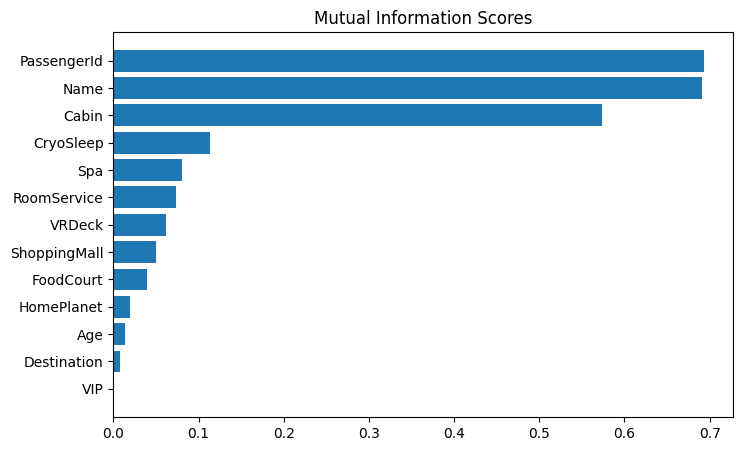

In [6]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

## Feature Engineering

PassengerID, Cabin, and Name all have values we can break apart to get more details

In [7]:
feat_X = df.copy()
feat_X.dropna()

feat_X[['Group', 'Member']] = feat_X['PassengerId'].str.split('_', expand=True)
feat_X['TotalGroupSize'] = feat_X.groupby('Group')['PassengerId'].transform('size')

feat_X[['FirstName', 'LastName']] = feat_X['Name'].str.split(' ', expand=True)

feat_X[['Deck', 'RoomNumber', 'Side']] = feat_X['Cabin'].str.split('/', expand=True)

feat_X['TotalSpent'] = feat_X['RoomService'] + feat_X['FoodCourt'] + feat_X['ShoppingMall'] + feat_X['Spa'] + feat_X['VRDeck']
feat_X['AverageSpentByHomePlanet'] = feat_X.groupby('HomePlanet')['TotalSpent'].transform('mean')
feat_X['AverageSpentByGroup'] = feat_X.groupby('Group')['TotalSpent'].transform('mean')
feat_X['TotalAmentitiesUsed'] = feat_X[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].gt(0).sum(axis=1)

feat_X['AverageAgeByGroup'] = feat_X.groupby('Group')['Age'].transform('mean')

feat_y = feat_X['Transported']

# Label encoding for categoricals
for colname in feat_X.select_dtypes("object"):
    feat_X[colname], _ = feat_X[colname].factorize()
    
discrete_features = feat_X.dtypes == int
discrete_features
feat_X.head()


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,FirstName,LastName,Deck,RoomNumber,Side,TotalSpent,AverageSpentByHomePlanet,AverageSpentByGroup,TotalAmentitiesUsed,AverageAgeByGroup
0,0,0,0,0,0,39.0,0,0.0,0.0,0.0,...,0,0,0,0,0,0.0,3543.302451,0.0,0,39.0
1,1,1,0,1,0,24.0,0,109.0,9.0,25.0,...,1,1,1,0,1,736.0,691.678632,736.0,5,24.0
2,2,0,0,2,0,58.0,1,43.0,3576.0,0.0,...,2,2,2,0,1,10383.0,3543.302451,7779.5,4,45.5
3,3,0,0,2,0,33.0,0,0.0,1283.0,371.0,...,3,2,2,0,1,5176.0,3543.302451,7779.5,4,45.5
4,4,1,0,3,0,16.0,0,303.0,70.0,151.0,...,4,3,1,1,1,1091.0,691.678632,1091.0,5,16.0


**Cluster with k-Means**

In [8]:

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_feat_X = feat_X.copy()
scaled_feat_X = scaled_feat_X.drop(['Transported'], axis=1)
scaled_feat_X = scaler.fit_transform(scaled_feat_X)

kmeans = KMeans(n_clusters=5)
feat_X['Cluster'] = kmeans.fit_predict(scaled_feat_X)
feat_X['Cluster'] = feat_X['Cluster'].astype('category')

scaled_feat_X = feat_X.copy()

feat_X.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,LastName,Deck,RoomNumber,Side,TotalSpent,AverageSpentByHomePlanet,AverageSpentByGroup,TotalAmentitiesUsed,AverageAgeByGroup,Cluster
0,0,0,0,0,0,39.0,0,0.0,0.0,0.0,...,0,0,0,0,0.0,3543.302451,0.0,0,39.0,2
1,1,1,0,1,0,24.0,0,109.0,9.0,25.0,...,1,1,0,1,736.0,691.678632,736.0,5,24.0,2
2,2,0,0,2,0,58.0,1,43.0,3576.0,0.0,...,2,2,0,1,10383.0,3543.302451,7779.5,4,45.5,4
3,3,0,0,2,0,33.0,0,0.0,1283.0,371.0,...,2,2,0,1,5176.0,3543.302451,7779.5,4,45.5,4
4,4,1,0,3,0,16.0,0,303.0,70.0,151.0,...,3,1,1,1,1091.0,691.678632,1091.0,5,16.0,2


**Take a look at the new features**

In [9]:
def make_mi_scores(feat_X, y, discrete_features):
    mi_scores = mutual_info_classif(feat_X, feat_y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=feat_X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

discrete_features = feat_X.dtypes == int
discrete_features

mi_scores = make_mi_scores(feat_X, feat_y, discrete_features)
mi_scores[::3]

Transported            0.693953
Cabin                  0.573596
LastName               0.235633
TotalAmentitiesUsed    0.119439
AverageSpentByGroup    0.083483
VRDeck                 0.056486
Deck                   0.024093
Age                    0.016684
TotalGroupSize         0.005742
VIP                    0.000902
Name: MI Scores, dtype: float64

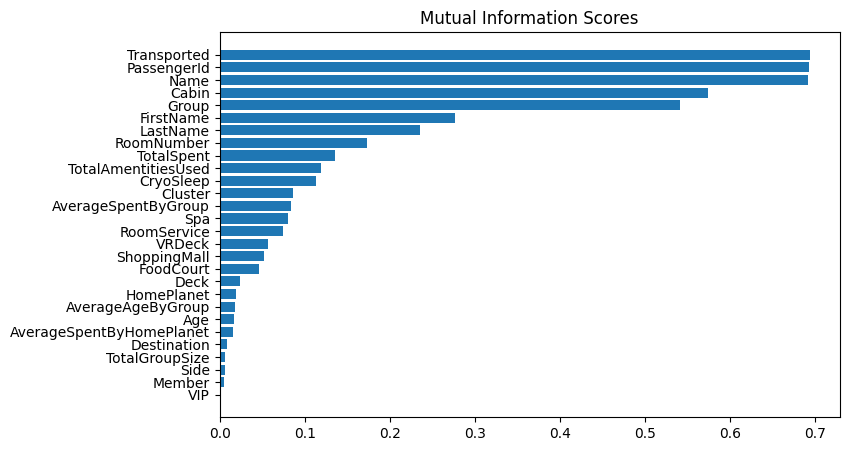

In [10]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

## Train a model as a baseline

In [35]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

train_columns = ['Cabin', 'Group', 'FirstName', 'LastName', 'RoomNumber', 'TotalSpent', 'TotalAmentitiesUsed', 'CryoSleep', 'Cluster', 'Spa', 'RoomService', 'VRDeck']

X_value = scaler.fit_transform(feat_X[train_columns])
y_value = feat_y

X_train, X_test, y_train, y_test = train_test_split(X_value, y_value, test_size=0.2, random_state=42)
                                                    
catboost_model = CatBoostClassifier(iterations=30, random_seed=42)
catboost_model.fit(X_train, y_train, verbose=False)


y_pred = catboost_model.predict(X_test)
y_pred = [True if label == 'True' else False for label in y_pred]

accuracy = accuracy_score(y_test, y_pred)
print(f"Base Catboost Accuracy :: {accuracy:.2f}")

Base Catboost Accuracy :: 0.81


## PCA Analysis

In [ ]:
from sklearn.decomposition import PCA

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_value)

# Convert to dataframe
#X_pca.shape[1]
component_names = [f"PC{i+1}" for i in range(5)]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
0,2.364229,-2.552756,-0.756900,-0.638198,-0.050627,-0.020511,0.036781,-0.073423,-1.012736,0.705899,0.011079,0.001054
1,3.168040,-1.080747,-1.837151,-0.783773,0.034663,-0.741550,-0.147371,-0.058784,0.481509,-0.857643,0.320026,0.001100
2,5.605556,1.837735,0.597324,-2.082283,4.427876,0.301402,-0.241129,0.167401,0.229506,-0.046176,-0.251689,0.000958
3,4.572955,0.259406,-0.215395,-1.306932,1.901555,-0.359159,-0.151313,-0.430690,0.224384,-0.258727,-0.469128,0.001028
4,3.215350,-0.982234,-1.939388,-0.585602,0.114267,-0.556250,-0.099032,-0.068701,0.502858,-0.810188,0.325118,0.001045


In [40]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=train_columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
Cabin,-0.425017,0.320105,0.070948,-0.056809,0.008952,0.034484,0.045258,-0.391895,-0.120798,-0.065205,0.181751,0.707005
Group,-0.425048,0.320125,0.071038,-0.056662,0.008898,0.034439,0.045195,-0.391607,-0.120728,-0.065294,0.181524,-0.707209
FirstName,-0.202502,0.224723,0.269718,0.401555,-0.087551,-0.077155,-0.766849,0.263157,0.018813,0.013473,-0.055095,0.000169
LastName,-0.206835,0.233531,0.302353,0.346133,-0.027800,-0.383711,0.601470,0.422373,0.038100,0.007948,-0.042070,0.000143
RoomNumber,-0.430982,0.143851,-0.252014,-0.294138,0.045683,0.142572,0.006965,0.154949,0.290998,0.194736,-0.688810,0.000103
TotalSpent,0.272800,0.425008,0.165525,-0.081185,0.102305,0.293748,0.040617,0.045187,0.410385,0.588212,0.310008,-0.000070
TotalAmentitiesUsed,0.208631,0.395898,-0.386629,-0.037078,-0.100905,-0.309035,-0.065854,-0.029568,0.513665,-0.513276,0.103350,0.000024
CryoSleep,-0.174956,-0.359684,0.462163,0.079592,0.129936,0.359856,0.069373,-0.087159,0.560753,-0.382449,0.024244,0.000047
Cluster,0.385631,0.135758,0.337745,0.186318,-0.064161,-0.202213,0.028687,-0.569030,0.032038,0.077473,-0.554453,0.000012
Spa,0.187117,0.280365,0.192923,-0.239188,0.762292,0.047905,-0.056024,0.185048,-0.258232,-0.300389,-0.119457,0.000022


array([<Axes: title={'center': '% Explained Variance'}, xlabel='Component'>,
       <Axes: title={'center': '% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

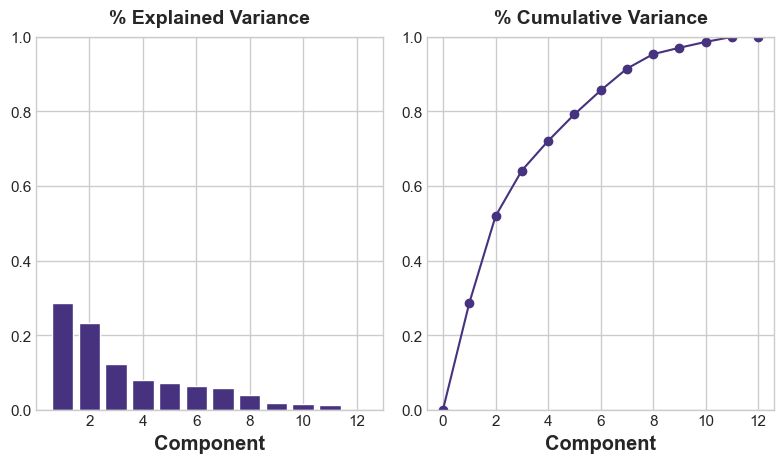

In [42]:
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


plot_variance(pca)

In [44]:
from sklearn.decomposition import PCA

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_val)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
0,2.364229,-2.552756,-0.756900,-0.638198,-0.050627,-0.020511,0.036781,-0.073423,-1.012736,0.705899,0.011079,0.001054
1,3.168040,-1.080747,-1.837151,-0.783773,0.034663,-0.741550,-0.147371,-0.058784,0.481509,-0.857643,0.320026,0.001100
2,5.605556,1.837735,0.597324,-2.082283,4.427876,0.301402,-0.241129,0.167401,0.229506,-0.046176,-0.251689,0.000958
3,4.572955,0.259406,-0.215395,-1.306932,1.901555,-0.359159,-0.151313,-0.430690,0.224384,-0.258727,-0.469128,0.001028
4,3.215350,-0.982234,-1.939388,-0.585602,0.114267,-0.556250,-0.099032,-0.068701,0.502858,-0.810188,0.325118,0.001045


## Retrain

In [45]:
# Not Using: 'CryoSleep', 'Cluster', 'Spa', 'RoomService', 'VRDeck'

train_columns = ['Cabin', 'Group', 'FirstName', 'LastName', 'RoomNumber', 'TotalSpent', 'TotalAmentitiesUsed', ]

X_value = scaler.fit_transform(feat_X[train_columns])
y_value = feat_y

X_train, X_test, y_train, y_test = train_test_split(X_value, y_value, test_size=0.2, random_state=42)
                                                    
catboost_model = CatBoostClassifier(iterations=30, random_seed=42)
catboost_model.fit(X_train, y_train, verbose=False)


y_pred = catboost_model.predict(X_test)
y_pred = [True if label == 'True' else False for label in y_pred]

accuracy = accuracy_score(y_test, y_pred)
print(f"PCA Revised Catboost Accuracy :: {accuracy:.2f}")

PCA Revised Catboost Accuracy :: 0.72


In [46]:
import plotly.express as px

sns.set(style="ticks", palette="viridis")

# Create a pairplot for each cluster
pairplot = sns.pairplot(feat_X, hue='Cluster', palette="viridis", plot_kws={'alpha':0.6}, diag_kind='hist', diag_kws={'alpha':0.6})

KeyboardInterrupt: 